# Шрифтоманы ли наши пользователи?
Для части пользователей мы изменили шрифты  в приложении, для спокойства менеджеров и был задуман данный проект

Целью проекта является изучение поведения пользователей в приложении по реализации продуктов питания.  
Для исследования имеем фрем со следующими данными :  
EventName — название события;  
DeviceIDHash — уникальный идентификатор пользователя;  
EventTimestamp — время события;  
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная;
Будут выполнены следующие шаги:  
1. Проверим входящие данные на пропуски и дубли, и добавим два столца с датой и временем и датой.  
2. Найдем общее количество событий и пользователей в логе. Расчитаем среднее количество событий на пользователя.  
3. Рассмотрим данными за какой период мы распологаем. Определим дату с которой даннные можно считать полными и в соответствии с этим отбросим более старые.  
4. Проверим фрейм на наличие пользователей из каждой экспериментальной группы.  
5. Рассмотрим имеющиеся в логах виды событий и найдем количество пользователей, которые совершали их. Подсчитаем долю пользователей которые хоть раз совершали событие.  
6. Построим предположение о последовательности событий, отбросим те из них, которые не укладываются в цепочку.  
7. Подсчитаем процент пользователей перешедших на следующий этап воронки. Определим на каком шаге отпадает наибольшее число пользователей и долю пользователей которые проходят всю цепочку событий.  
8. Найдем количество пользователей в каждой экспериментальной группе и проверим корректность груп для А/А экспериментов при помощи статистических критериев.  
9. Найдем самое популярное событие и посчитаем число пользователей в каждой контрольной группе. Проверим будет ли отличие между группами статистически достоверными.  
10. Сделаем аналогичные с пунктом 9  действия для группы с измененным шрифтом.  


## Предобработка данных

#### 1. Проверим входящие данные на пропуски и дубли, и добавим два столца с датой и временем и датой

In [1]:
import pandas as pd 
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import stats as st
import numpy as np
import math as mth
import cmath

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep = '\t' )

In [3]:
df.columns = ['event', 'id', 'eventdate', 'expid']
df['date_time'] = pd.to_datetime(df['eventdate'], unit = 's')


In [4]:
df['date'] = df['date_time'].dt.date
#df['date_time'] = df['date_time'].astype('datetime64[h]')
df['date']= pd.to_datetime(df['date'])
df['date_time'] = df['date_time'].apply(lambda t: t.strftime('%Y-%m-%d %H'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
event        244126 non-null object
id           244126 non-null int64
eventdate    244126 non-null int64
expid        244126 non-null int64
date_time    244126 non-null object
date         244126 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


In [5]:
df = df.drop_duplicates().reset_index(drop= True)

Заменили названия колонок на более удобные, доавили столбцы с датой и временем и просто датой. Удалили дубликаты из фрейма (около 400 строк) 

##### 2. Найдем общее количество событий и пользователей в логе. Расчитаем среднее количество событий на пользователя 

In [6]:
logs_event = df['event'].count()
logs_users = df.agg({'id' : 'count','id':pd.Series.nunique })
print ('Количество событий = ', logs_event)
print('Количество уникальных пользователей = ', logs_users['id'] )
print('Среднее количестов событий на 1 пользователя = ', logs_event/logs_users['id'])

Количество событий =  243713
Количество уникальных пользователей =  7551
Среднее количестов событий на 1 пользователя =  32.27559263673685


Построим гистограмму по дате ти времени

In [7]:
logs_dates = df.pivot_table(index='date_time', values='id', aggfunc='count').reset_index()
logs_dates['date_time']= pd.to_datetime(logs_dates['date_time'])
logs_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 2 columns):
date_time    284 non-null datetime64[ns]
id           284 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.6 KB


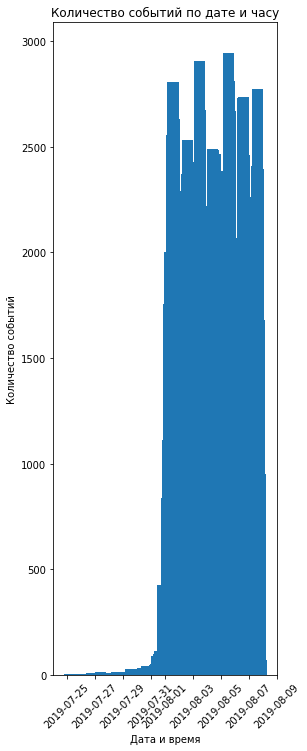

In [36]:
fig, ax = plt.subplots( figsize = (4,12) )
x = logs_dates['date_time']
y = logs_dates['id']
ax.bar(x,y)
plt.xticks(rotation = 45)
plt.xlabel('Дата и время')
plt.ylabel('Количество событий')
plt.title('Количество событий по дате и часу')
plt.show()

Резкое увеличение количества событий наблюдается 01.08.2019. Считаю что именно с этго момента "доехали старые данные" и имеем полные данные. Уберем данные до этого отрезка времени из нашего фрейма. Посмотрим сколько событий и пользователей при этом мы потеряли.

In [9]:
df_new = df[df['date'] >= "2019-08-01"]
logs_event_new = df_new['event'].count()
logs_users_new = df_new.agg({'id' : 'count','id':pd.Series.nunique })
print('Количество потерянных событий = ', logs_event - logs_event_new)
print('Количество потерынных пользователей = ', logs_users - logs_users_new)


Количество потерянных событий =  2826
Количество потерынных пользователей =  id    17
dtype: int64


In [10]:
df_new

,event,id,eventdate,expid,date_time,date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00,2019-08-01
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21,2019-08-07
243709,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21,2019-08-07
243710,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21,2019-08-07
243711,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21,2019-08-07


Потеряли ничтожно малое количество событий и пользователей относительно изначальных данных  (3 тысячи от 243 тысяч и 17 от 7551 ) не считаю эти потери критичными.

In [11]:
group_check = df_new.groupby('expid').agg({'id' : 'count','id':pd.Series.nunique})
group_check

,id
expid,
246,2484
247,2513
248,2537


В обновленных данных по прежнему присутствуют пользователи из всех 3 групп

Рассмотрим имеющиеся в логах виды событий и найдем количество пользователей, которые совершали их. Подсчитаем долю пользователей которые хоть раз совершали событие.

Количество событий и количество уникальных пользователей совершаю щих это события

In [12]:
event_type = df_new.groupby('event').agg({'id': 'count', 'id':pd.Series.nunique, 'event':'count'})
event_type.columns = ['id_count','event_count']
event_type = event_type.reset_index()
event_type['frequency'] = event_type['event_count'] / event_type['id_count']
event_type = event_type.sort_values(by = 'frequency', ascending = False)
event_type

,event,id_count,event_count,frequency
1,MainScreenAppear,7419,117328,15.814530
0,CartScreenAppear,3734,42303,11.329138
2,OffersScreenAppear,4593,46333,10.087742
3,PaymentScreenSuccessful,3539,33918,9.584063
4,Tutorial,840,1005,1.196429


Имеем следующие этапы в наших логах и складываются ву следующую воронку событий :  
1. MainScreenAppear - открытие главной страницы (самая часто посещаемая страница, что не странно)  
2. OffersScreenAppear - открытие страницы с предложениями  
3. CartScreenAppear - открытие страницы оплаты (или заполнений данных для оплаты)  
4. PaymentScreenSuccessful	 - открытие страницы с успешным завершением оплаты 


Tutorial - обучение не попадает в продуктовую воронку (и честно говоря плохо понимаю чему в  таком приложении можно учить, но скорее всего не прав)

In [13]:
uid_count = df_new['id'].agg({'id': 'count', 'id':pd.Series.nunique})
print ('Количество уникальных пользователей в логах = ',uid_count )

Количество уникальных пользователей в логах =  id    7534
Name: id, dtype: int64


In [14]:
event_type['share %'] = event_type['id_count'] / uid_count['id'] * 100
event_type_full_circle = event_type[event_type['event'] != 'Tutorial']
event_type_full_circle.sort_values(by = 'share %',ascending = False)

,event,id_count,event_count,frequency,share %
1,MainScreenAppear,7419,117328,15.814530,98.473586
2,OffersScreenAppear,4593,46333,10.087742,60.963632
0,CartScreenAppear,3734,42303,11.329138,49.561986
3,PaymentScreenSuccessful,3539,33918,9.584063,46.973719


В столбце  share посчитали долю пользователей с которыми происходило данное событие, сортировка по данному столбцу как раз дает нам нашу продуктовую воронку 

Подсчитаем процент пользователей перешедших на следующий этап воронки. Определим на каком шаге отпадает наибольшее число пользователей 

In [15]:
MainScreenAppear_user = event_type_full_circle.loc[1,'id_count']
OffersScreenAppear_user = event_type_full_circle.loc[2,'id_count']
CartScreenAppear_user  = event_type_full_circle.loc[0,'id_count'] 
PaymentScreenSuccessful_user = event_type_full_circle.loc[3,'id_count']     
lost_main_offers = (MainScreenAppear_user -OffersScreenAppear_user) / MainScreenAppear_user
lost_offers_cart = (OffersScreenAppear_user - CartScreenAppear_user) / OffersScreenAppear_user 
lost_cart_succes = (CartScreenAppear_user -PaymentScreenSuccessful_user) / CartScreenAppear_user
print(MainScreenAppear_user)
print(OffersScreenAppear_user)
print(CartScreenAppear_user)
print(PaymentScreenSuccessful_user)

7419
4593
3734
3539


In [16]:
print('Потери при переходе на экран с предложениями = {0:.0%}' .format(lost_main_offers) )
print('Потери при переходе на экран c внесением данных для оплаты =  {0:.0%}' .format(lost_offers_cart)  )
print('Потери при переходе на экран успешной оплатой = {0:.0%}' .format(lost_cart_succes))

Потери при переходе на экран с предложениями = 38%
Потери при переходе на экран c внесением данных для оплаты =  19%
Потери при переходе на экран успешной оплатой = 5%


Самые большие потери в пользователях наблюдаются на этапе перехода с главного экрана на 'кран с предложениями (39%)

In [17]:
lust_stand_boys = PaymentScreenSuccessful_user / MainScreenAppear_user
print('Доля пользователей которые прошли полный цикл = {0:.0%}' .format(lust_stand_boys))

Доля пользователей которые прошли полный цикл = 48%


Найдем количество пользователей в каждой экспериментальной группе и проверим корректность груп для А/А экспериментов при помощи статистических критериев.

Количество пользователей в каждой группе мы посчитали ранее

In [18]:
group_check = group_check.reset_index()
group_check

,expid,id
0,246,2484
1,247,2513
2,248,2537


In [19]:
df_new = df_new[df_new['event']!= 'Tutorial']
group_246 = df_new[df['expid'] == 246]
group_247 = df_new[df['expid'] == 247]
group_248 = df_new[df['expid'] == 248]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [20]:
group_246_ev = group_246.groupby('event').agg({'id': 'count', 'id':pd.Series.nunique})
group_246_ev.columns  = ['id_246']
group_246_ev

,id_246
event,
CartScreenAppear,1266
MainScreenAppear,2450
OffersScreenAppear,1542
PaymentScreenSuccessful,1200


In [21]:
group_247_ev = group_247.groupby('event').agg({'id': 'count', 'id':pd.Series.nunique})
group_247_ev.columns  = ['id_247']
group_247_ev

,id_247
event,
CartScreenAppear,1238
MainScreenAppear,2476
OffersScreenAppear,1520
PaymentScreenSuccessful,1158


In [22]:
group_248_ev = group_248.groupby('event').agg({'id': 'count', 'id':pd.Series.nunique})
group_248_ev.columns  = ['id_248']
group_248_ev

,id_248
event,
CartScreenAppear,1230
MainScreenAppear,2493
OffersScreenAppear,1531
PaymentScreenSuccessful,1181


In [23]:
group_all = group_246_ev.join(group_247_ev)
group_all['id_246_247']= group_all['id_246'] +group_all['id_247']
group_all = group_all.join(group_248_ev)
group_all

,id_246,id_247,id_246_247,id_248
event,,,,
CartScreenAppear,1266,1238,2504,1230
MainScreenAppear,2450,2476,4926,2493
OffersScreenAppear,1542,1520,3062,1531
PaymentScreenSuccessful,1200,1158,2358,1181


Напишем функцию для проверки нулевой гипотезы - между долями в А/А группах нет разницы. Гипотеза для А/А теста - между группами есть статистические различия, значение alpha выбираем = 0.01 - согласно с рекомендованным в методическом пособии. (различия между группами не более 1 %). Для А/В теста примем в 5% - считаю что если разница не более данного значения - нет видимых причин считать выборки разными

In [24]:
def true_or_not(s_p1,t_p1,s_p2,t_p2,alpha):
    #alpha = 0.01
    
    p1 = s_p1/t_p1
    p2 = s_p2/t_p2
    p_combined = (s_p1 + s_p2)/ (t_p1 + t_p2)
    difference = p1 - p2
    z_value = difference / cmath.sqrt(p_combined * (1-p_combined)*(1/t_p1 + 1/t_p2))
    distr = st.norm(0,1)
    p_value = (1 - distr.cdf(abs(z_value)))*2
    print('p-value = ', p_value)
    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу - между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными')

Будем проводить тест для каждого события в функции s_p1 и s_p2 - пользователи успешно достигшие события, а t_p1 и t_p2 - количество уникальных пользователей в каждой из груп

In [38]:
group_all = group_all.sort_values(by = 'id_246',ascending = False)
group_all = group_all.reset_index()
print(group_all)
print(group_check)

   level_0  index                    event  id_246  id_247  id_246_247  id_248
0        0      0         MainScreenAppear    2450    2476        4926    2493
1        1      1       OffersScreenAppear    1542    1520        3062    1531
2        2      2         CartScreenAppear    1266    1238        2504    1230
3        3      3  PaymentScreenSuccessful    1200    1158        2358    1181
   expid    id
0    246  2484
1    247  2513
2    248  2537


In [26]:
t_p1 = np.array(group_check['id'])[0]
t_p2 = np.array(group_check['id'])[1]
print(t_p1)
print(t_p2)
for i in range(len(group_all.index)):
    print('Проверка для события: ',group_all.iat[i,0])
    s_p1 = group_all.iat[i,1]
    s_p2 = group_all.iat[i,2]
    print('s_p1 =',s_p1)
    print("s_p1 =",s_p2)
    true_or_not(s_p1,t_p1,s_p2,t_p2, 0.01)

2484
2513
Проверка для события:  MainScreenAppear
s_p1 = 2450
s_p1 = 2476
p-value =  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  OffersScreenAppear
s_p1 = 1542
s_p1 = 1520
p-value =  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  CartScreenAppear
s_p1 = 1266
s_p1 = 1238
p-value =  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  PaymentScreenSuccessful
s_p1 = 1200
s_p1 = 1158
p-value =  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными


s_p1 и s_p2 - это число успехов, количество уникальных пользователей попавших на определенный этап  
t_p1 и t_p2 - это число попыток - количество уникальных пользователей в грууппе (выбиралось именно оно по совету наставника с слаке)  
Проверил и то и то теперь (после работой над таблицей таблицей) берутся именно те значения которые я планировал   
Выводы не значений этих элементов не стал убирать при проведении А/А теста для наглядности

Так же проверим что расхождение ключевых метрик не превышает 1% 

In [27]:
for i in range(len(group_all.index)):
    res = abs((group_all.iat[i,1]  - group_all.iat[i,2])/group_all.iat[i,1])
    print('Различие по количеству пользователей = {0:.1%}'.format(res))

Различие по количеству пользователей = 1.1%
Различие по количеству пользователей = 1.4%
Различие по количеству пользователей = 2.2%
Различие по количеству пользователей = 3.5%


Расхождение между ключевыми метриками по группам в среднем 2 % - больше чем рекомендуемое значение в 1 % . После применения статистических критериев не было выявлено различия между группами А/А теста

Теперь проверим будет ли статистическое различие между группами А,А, А+А и группой В .

Нулевая гипотеза для всех проверок - между между группами   нет значимой разницы

In [28]:
t_p1 = np.array(group_check['id'])[0]
t_p2 = np.array(group_check['id'])[2]

for i in range(len(group_all.index)):
    print('Проверка для события: ',group_all.iat[i,0])
    s_p1 = group_all.iat[i,1]
    s_p2 = group_all.iat[i,4]
    true_or_not(s_p1,t_p1,s_p2,t_p2, 0.05)

Проверка для события:  MainScreenAppear
p-value =  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  OffersScreenAppear
p-value =  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  CartScreenAppear
p-value =  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  PaymentScreenSuccessful
p-value =  0.21225532756977983
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными


In [29]:
t_p1 = np.array(group_check['id'])[1]
t_p2 = np.array(group_check['id'])[2]

for i in range(len(group_all.index)):
    print('Проверка для события: ',group_all.iat[i,0])
    s_p1 = group_all.iat[i,2]
    s_p2 = group_all.iat[i,4]
    true_or_not(s_p1,t_p1,s_p2,t_p2, 0.05)

Проверка для события:  MainScreenAppear
p-value =  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  OffersScreenAppear
p-value =  0.9197817830592259
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  CartScreenAppear
p-value =  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  PaymentScreenSuccessful
p-value =  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными


В обоих случаях получаем что между группами А и В нет различий.

И для объединенных А А групп

In [30]:
t_p1 = np.array(group_check['id'])[0] + np.array(group_check['id'])[1]
t_p2 = np.array(group_check['id'])[2]
for k in range(len(group_all.index)):
        print('Проверка для события: ',group_all.iat[k,0])
        s_p1 = group_all.iat[k,3]
        s_p2 = group_all.iat[k,4]
        true_or_not(s_p1,t_p1,s_p2,t_p2, 0.05)

Проверка для события:  MainScreenAppear
p-value =  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  OffersScreenAppear
p-value =  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  CartScreenAppear
p-value =  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  PaymentScreenSuccessful
p-value =  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными


Для объединенной группы АА и В все равно получаем что нет разницы. 

Сравния различия по всем событиям, мы несколько раз сравниваем выборки из одной ген. совокупности - имеем дело с множественным статистическим анализом. С целью уменьшения групповой ошибки первого рода, следует применить поправку к выбранному уровню значимости. Для этого применим метод  Бонферрони

In [31]:
alpha = 0.05/16

In [32]:
t_p1 = np.array(group_check['id'])[0]
t_p2 = np.array(group_check['id'])[2]

for i in range(len(group_all.index)):
    print('Проверка для события: ',group_all.iat[i,0])
    s_p1 = group_all.iat[i,1]
    s_p2 = group_all.iat[i,4]
    true_or_not(s_p1,t_p1,s_p2,t_p2, alpha)

Проверка для события:  MainScreenAppear
p-value =  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  OffersScreenAppear
p-value =  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  CartScreenAppear
p-value =  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  PaymentScreenSuccessful
p-value =  0.21225532756977983
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными


In [33]:
t_p1 = np.array(group_check['id'])[1]
t_p2 = np.array(group_check['id'])[2]

for i in range(len(group_all.index)):
    print('Проверка для события: ',group_all.iat[i,0])
    s_p1 = group_all.iat[i,2]
    s_p2 = group_all.iat[i,4]
    true_or_not(s_p1,t_p1,s_p2,t_p2, alpha)

Проверка для события:  MainScreenAppear
p-value =  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  OffersScreenAppear
p-value =  0.9197817830592259
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  CartScreenAppear
p-value =  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  PaymentScreenSuccessful
p-value =  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными


In [34]:
t_p1 = np.array(group_check['id'])[0] + np.array(group_check['id'])[1]
t_p2 = np.array(group_check['id'])[2]
for i in range(len(group_all.index)):
        print('Проверка для события: ',group_all.iat[i,0])
        s_p1 = group_all.iat[i,3]
        s_p2 = group_all.iat[i,4]
        true_or_not(s_p1,t_p1,s_p2,t_p2, alpha)

Проверка для события:  MainScreenAppear
p-value =  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  OffersScreenAppear
p-value =  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  CartScreenAppear
p-value =  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными
Проверка для события:  PaymentScreenSuccessful
p-value =  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу - нет основания считать доли разными


После внесенных правок в значение коэффициентов alpha, по прежнему получаем что нет повода считать что есть разницы между группами

## Вывод   
Входящий фрейм был обработан на дубликаты и пустые значения.  
Были посчитаны:  
1. Общее количество пользователей (7551) и событий (243713).
2. Среднее количество событий на пользователя (32).
3. Доля пользователей которые хоть раз совершали событие (98.47).  
Составлено предположение о последовательности событий :  
1. MainScreenAppear - открытие главной страницы 
2. OffersScreenAppear - открытие страницы с предложениями  
3. CartScreenAppear - открытие страницы оплаты (или заполнений данных для оплаты)  
4. PaymentScreenSuccessful	 - открытие страцы с успешнвм завершением оплаты  
Подсчитали процент польхователей переходящих от одного этапа воронки на другой. Получили,что наибольшая потеря пользователей происходит на этапе перехода от главного экрана к открытию страницы с предложением (61%)
При помощи статистических методов сравнили группы с измененным шрифтом и без него , получили что различие между выборки из 12 проведенных тестов только в 1 есть различие.

# Итог
Считаю, что  изменение шрифта не принесло никаких значимых изменений (как в положительную так и в отрицательную сторону). Можно успокоить менеджеров - показатели не изменились.